# Gaussian Process Regression with GpABC.jl

In [11]:
using GpABC, Distributions, Plots

Define the latent function that we are going to approximate:

In [12]:
f(x) = x * x + 10 * sin(x) 

f (generic function with 1 method)

Set up some training and test data. Random noise is added to observations in training points, to make the task a little bit harder.

In [13]:
n = 30
training_x = sort(rand(Uniform(-10, 10), n))
training_y = f.(training_x)
training_y += 20 * (rand(n) .- 0.5) # add some noise
test_x = range(min(training_x...), stop=max(training_x...), length=1000) |> collect;


`SquaredExponentialIsoKernel` will be used by default. Assume we already know its hyperparameters:

$$
\begin{align*}
    \sigma_f &= 37.08 \\
    l &= 1.0 \\
    \sigma_n &= 6.58
\end{align*}
$$

In [14]:
hypers = [37.08, 1.0, 6.58];

Run the regression and plot the results

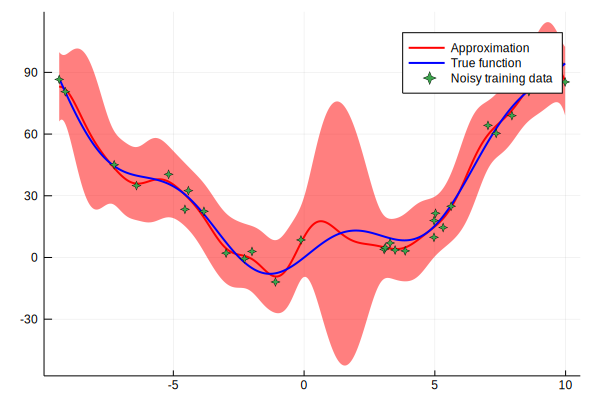

In [15]:
gpm = GPModel(training_x, training_y)
set_hyperparameters(gpm, hypers)
test_y, test_var = gp_regression(test_x, gpm)

plot(test_x, test_y, ribbon=1.96 * sqrt.(test_var), c=:red, linewidth=2, label="Approximation")
plot!(test_x, f.(test_x), c=:blue, linewidth=2, label="True function")
scatter!(training_x, training_y, m=:star4, label="Noisy training data")

Now let's find the optimal values for kernel hyperparameters:

In [16]:
gp_train(gpm)

3-element Array{Float64,1}:
 53.287103033280545
  2.847048902473345
  5.163041966423771

Re-run the regression with optimised hyperparameters, and plot the results

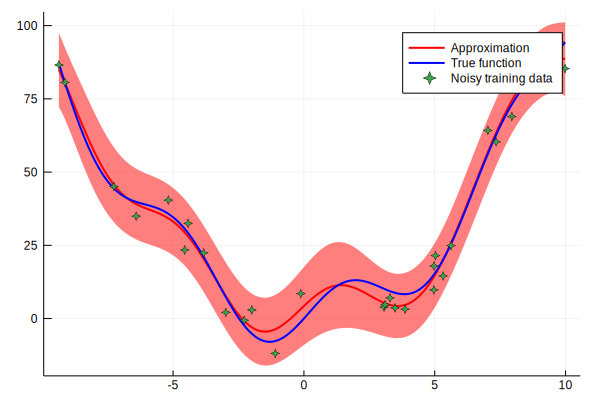

In [17]:
test_y, test_var = gp_regression(test_x, gpm)

plot(test_x, test_y, ribbon=1.96 * sqrt.(test_var), c=:red, linewidth=2, label="Approximation")
plot!(test_x, f.(test_x), c=:blue, linewidth=2, label="True function")
scatter!(training_x, training_y, m=:star4, label="Noisy training data")

An example of more advanced usage of `gp_train`

In [18]:
import Optim.SimulatedAnnealing
gpm = GPModel(training_x, training_y)
gp_train(gpm; optimiser=SimulatedAnnealing(), 
    hp_lower=exp.([-10.0, -1.0, -10.0]), 
    hp_upper=exp.([10.0, 2.0, 10.0]), 
    log_level=1)

Bound optimisation using SimulatedAnnealing{typeof(Optim.default_neighbor!),typeof(Optim.log_temperature)}. Gradient provided. Start point: [1.0, 1.0, 1.0]; lower bound: [-10.0, -1.0, -10.0]; upper bound: [10.0, 2.0, 10.0]
Results of Optimization Algorithm
 * Algorithm: Fminbox with Simulated Annealing
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [3.861084651710313,1.03883295329023, ...]
 * Minimum: 1.138793e+02
 * Iterations: 4
 * Convergence: true
   * |x - x'| ≤ 0.0e+00: true 
     |x - x'| = 0.00e+00 
   * |f(x) - f(x')| ≤ 0.0e+00 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.80e+01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 10010
 * Gradient Calls: 0
Optimized log hyperparameters: [3.86108, 1.03883, 1.66521]
Optimized hyperparameters: [47.5169, 2.82592, 5.2868]


3-element Array{Float64,1}:
 47.51686267425899  
  2.8259171118884296
  5.286801320669964 